# Covid19 Predicition
### by Kashin Gupta

Machine learning has numerous tools that can be used for visualization and prediction, and nowadays it is used worldwide for study of the pattern of COVID-19 spread. One of the main focus of the study in this project is to use machine learning techniques to analyze, visualize and Predict the spreading of the virus country-wise as well as globally during a specific period of time by considering confirmed cases, recovered cases and fatalities. This Notebook Covers the Prediction part of Covid19.

**Data Sources** : __[COVID-19 datasets from Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)__

**More information** :  __[World Health Organisation(WHO)](https://www.who.int/emergencies/diseases/novel-coronavirus-2019)__

## Current Date and time

In [45]:
from datetime import datetime
print(datetime.now())

2022-12-16 19:13:52.469313


In [46]:
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

### Read datasets

In [48]:

covid19_date_country=pd.read_csv('covid19_date_country.csv')
india_df=pd.read_csv('covid19_india.csv')
covid19_country_latest=pd.read_csv('covid19_country_latest.csv')
covid19_world=pd.read_csv('covid19_world.csv')

## ARIMA Model

In [49]:
covid19_world = pd.read_csv('covid19_world.csv')
df = covid19_world[['Date', 'Confirmed']]
df.head()

,Date,Confirmed
0,2020-01-22,557
1,2020-01-23,655
2,2020-01-24,941
3,2020-01-25,1433
4,2020-01-26,2118


In [50]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].head()

0   2020-01-22
1   2020-01-23
2   2020-01-24
3   2020-01-25
4   2020-01-26
Name: Date, dtype: datetime64[ns]

In [51]:
df.set_index('Date', inplace = True)
df.head()

,Confirmed
Date,
2020-01-22,557
2020-01-23,655
2020-01-24,941
2020-01-25,1433
2020-01-26,2118


In [52]:
df.shape

(412, 1)

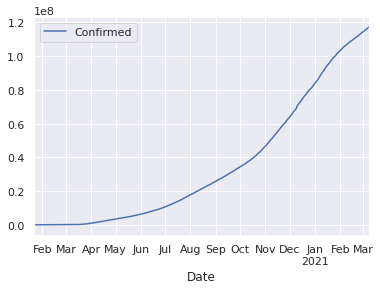

In [53]:
df.plot()

In [54]:
n = 350  # days used to predict
data = df[:n]

In [55]:
# check for Stationarity

from statsmodels.tsa.stattools import adfuller

result = adfuller(data.values)
print('ADF Statistic: %f' %result[0])
print('p-value: %f' %result[1])

ADF Statistic: 2.186470
p-value: 0.998871


In [56]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(data.values, start_p = 1, start_q = 1, 
                     test = 'adf', max_p = 7, max_q = 7, max_d = 2, 
                     m = 1, d= None, seasonal = False, 
                     start_P = 0 , trace= True, D = 0, 
                     error_action = 'ignore', stepwise = True, suppress_warnings =True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8704.338, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=8794.639, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=8767.408, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8715.629, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=8792.931, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=8700.069, Time=0.45 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=8765.080, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=8666.277, Time=0.23 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=8742.434, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=8629.590, Time=0.29 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=8685.435, Time=0.13 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=8611.007, Time=0.50 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=8632.876, Time=0.22 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=8601.854, Time=0.57 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept

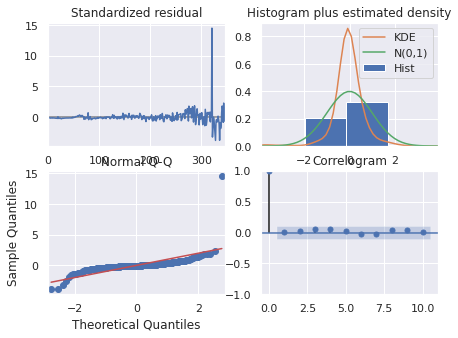

In [57]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [58]:
periods = len(df) - n

# forecast
fc, confint = model.predict(n_periods = periods, return_conf_int = True)
index = np.arange(len(data.values), len(data.values) + periods)

In [59]:
Actual_confirmed_cases = df[n:]
index = df.index[n:]
predicted_confirmed_cases = pd.Series(fc, index = index)

In [60]:
# Series for plotting
fc_series = pd.Series(fc, index = index)
lower_series = pd.Series(confint[:,0], index = index)
upper_series = pd.Series(confint[:,1], index=  index)

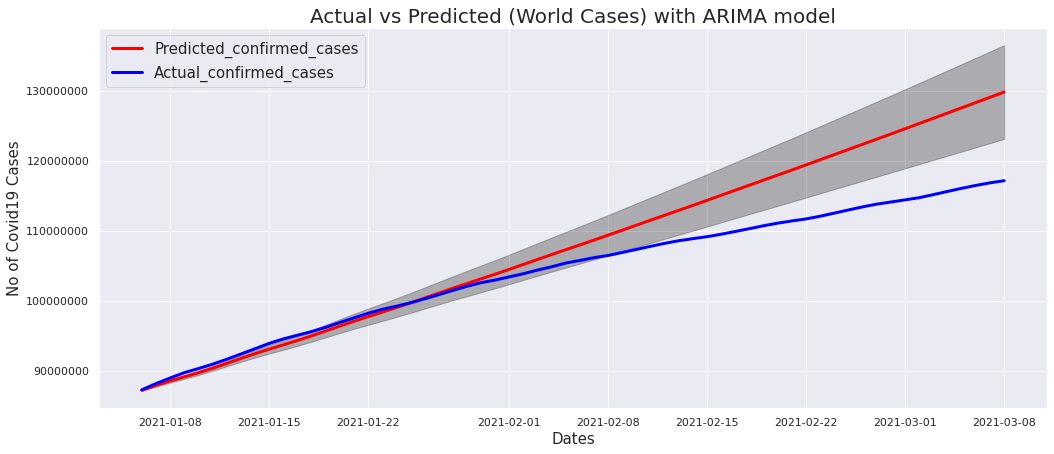

In [61]:
fig = plt.figure(figsize = (17, 7))
axes = fig.subplots(1, 1)
plt.ticklabel_format(style = 'plain', axis = 'y')
axes.set_title('Actual vs Predicted (World Cases) with ARIMA model', fontsize = 20)
axes.set_xlabel('Dates', fontsize =15)
axes.set_ylabel('No of Covid19 Cases', fontsize = 15)

axes.plot(predicted_confirmed_cases, color= 'Red', label = 'Predicted_confirmed_cases', lw = 3)
axes.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.3)
axes.plot(Actual_confirmed_cases, color = 'blue', label = 'Actual_confirmed_cases', lw = 3)
plt.legend(loc = 'upper left', fontsize = 15)

**Note:** there is 95% confidence interval i.e our prediction lies within shadow Region 

In [62]:
# Calculating Accuracy

def calculate_forecast_acuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    return mape

mean_absolute_percentage_error = calculate_forecast_acuracy(fc, Actual_confirmed_cases['Confirmed'])
print('mean_absolute_percentage_error :%f' %mean_absolute_percentage_error)

mean_absolute_percentage_error :0.035679


Prediction for India Confirmed cases

In [63]:
covid19_india = pd.read_csv('covid19_india.csv')
df = covid19_india[['Confirmed','Date']]

In [64]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

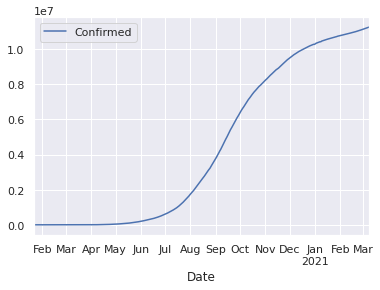

In [65]:
df.plot()

In [66]:
# days used for prediction
n = 350
data = df[:n]

In [67]:
# check for Stationarity

from statsmodels.tsa.stattools import adfuller

result = adfuller(data.values)
print('ADF Statistic: %f' %result[0])
print('p-value: %f' %result[1])

ADF Statistic: -0.544783
p-value: 0.882977


In [68]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(data.values, start_p = 1, start_q = 1, 
                     test = 'adf', max_p = 7, max_q = 7, max_d = 3, 
                     m = 1, d= None, seasonal = False, 
                     start_P = 0 , trace= True, D = 0, 
                     error_action = 'ignore', stepwise = True, suppress_warnings =True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8013.566, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11791.108, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11538.952, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6871.470, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7876.282, Time=0.72 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6866.113, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8097.759, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6894.699, Time=0.44 sec


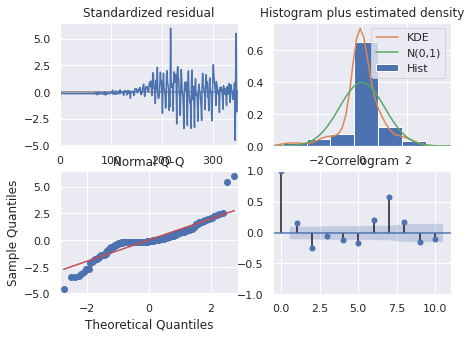

In [69]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [70]:
# prediction for (len(df) - n) no of days i.e 12

periods = len(df) - n
print(periods)

# forecast
fc, confint = model.predict(n_periods = periods, return_conf_int = True)
index = np.arange(len(data.values), len(data.values) + periods)

62


In [71]:
Actual_confirmed_cases = df[n:]
index = df.index[n:]
predicted_confirmed_cases = pd.Series(fc, index = index)

In [72]:
# Series for plotting
fc_series = pd.Series(fc, index = index)
lower_series = pd.Series(confint[:,0], index = index)
upper_series = pd.Series(confint[:,1], index=  index)

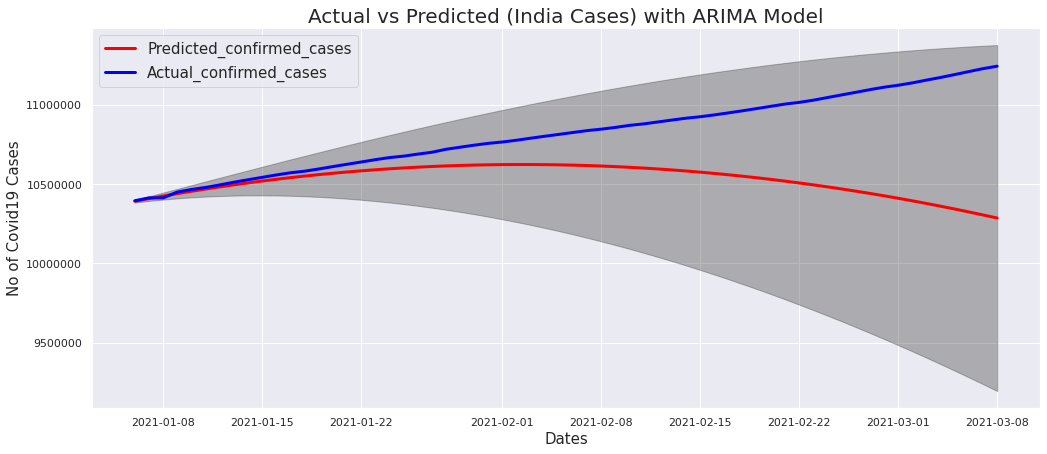

In [73]:
fig = plt.figure(figsize = (17, 7))
axes = fig.subplots(1, 1)
plt.ticklabel_format(style = 'plain', axis = 'y')
axes.set_title('Actual vs Predicted (India Cases) with ARIMA Model', fontsize = 20)
axes.set_xlabel('Dates', fontsize =15)
axes.set_ylabel('No of Covid19 Cases', fontsize = 15)

axes.plot(predicted_confirmed_cases, color= 'Red', label = 'Predicted_confirmed_cases', lw = 3)
axes.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.3)
axes.plot(Actual_confirmed_cases, color = 'blue', label = 'Actual_confirmed_cases', lw = 3)
plt.legend(loc = 'upper left', fontsize = 15)

In [74]:
# Calculating Accuracy

def calculate_forecast_acuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    return mape

mean_absolute_percentage_error = calculate_forecast_acuracy(fc, Actual_confirmed_cases['Confirmed'])
print('mean_absolute_percentage_error :%f' %mean_absolute_percentage_error)

mean_absolute_percentage_error :0.026659


**Note:** mean_absolute-percentage_error shows that our model is 98% accurate as there is an error of only 2%

### Predictions using Linear regression

In [75]:
X = pd.to_datetime(covid19_world['Date'])
X = X.map(datetime.toordinal)
y = covid19_world['Confirmed']

In [76]:
X = np.array(X).reshape((-1, 1))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle  = False)
print('No of days as input', X_train.size)
print('No of days for Predictions', X_test.size)

No of days as input 329
No of days for Predictions 83


In [78]:
polynomial_regression = Pipeline([
                                ('poly_features', PolynomialFeatures(degree = 4, include_bias  = False)),
                                ('std_scaler', StandardScaler()), 
                                ('lin_reg', LinearRegression())
                                ])

In [79]:
polynomial_regression.fit(X_train, y_train)

Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('lin_reg', LinearRegression())])

In [80]:
predicted_confirmed_cases = polynomial_regression.predict(X_test)

In [81]:
Dates = covid19_world['Date'].iloc[305:]
Dates = pd.to_datetime(Dates)
actual_confirmed_cases = y_test

In [82]:
# calculate accuracy
mape = calculate_forecast_acuracy(predicted_confirmed_cases, actual_confirmed_cases)
print('mean absolute percentage error: %.4f' %(mape* 100))

mean absolute percentage error: 9.4038


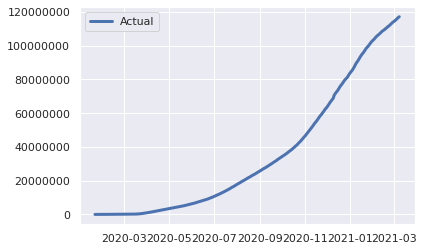

In [83]:
# Another plot
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.plot(pd.to_datetime(covid19_world['Date']), covid19_world['Confirmed'],label =  'Actual', lw = 3)
plt.legend()